In [52]:
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In [53]:
import json

def load_data(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return data
data=load_data('MentalhealthcareData.json')

In [54]:
# !pip install spacy
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 7.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [55]:
nlp = spacy.load('en_core_web_md')

In [56]:

def advanced_preprocess_text(text):
    doc = nlp(text.lower())
    cleaned_text = []
    skip_next = False
    for token in doc:
        if skip_next:
            skip_next = False
            continue
        if token.text == 'not' and token.i + 1 < len(doc):
            cleaned_text.append(token.text + '_' + doc[token.i + 1].lemma_)
            skip_next = True
        elif not token.is_stop and not token.is_punct and token.lemma_ != "-PRON-":
            if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']:
                cleaned_text.append(token.lemma_)
    return " ".join(cleaned_text)

# Example use:
text_example = "This is an example2 sentence to demonstrate the simple preprocessing function.."
processed_text = advanced_preprocess_text(text_example)
print(processed_text)  # Check output to see if it makes sense and isn't single characters


example2 sentence demonstrate simple preprocessing function


In [57]:
# Preprocess patterns in intents
for intent in data['intents']:
  intent['processed_pattern']   = advanced_preprocess_text(intent['pattern'])

In [58]:
for intent in data['intents'][:5]:
    original_text = intent['pattern']
    preprocessed_text =  intent['processed_pattern']
    print(f"Original: {original_text}\nPreprocessed: {preprocessed_text}\n")

Original: How do I navigate cultural differences with my partner's family?
Preprocessed: navigate cultural difference partner family

Original: What should I do if my partner and I have different levels of emotional intelligence?
Preprocessed: partner different level emotional intelligence

Original: How can I support my partner through a career transition?
Preprocessed: support partner career transition

Original: What should I do if my partner and I have different parenting styles?
Preprocessed: partner different parenting style

Original: How do I handle disagreements about money with my partner?
Preprocessed: handle disagreement money partner



In [59]:
#Convert JSON data into Dataframe
df = pd.json_normalize(data['intents'])




In [60]:
df.head()

,tag,pattern,response,processed_pattern
0,relationship,How do I navigate cultural differences with my...,Navigating cultural differences with your part...,navigate cultural difference partner family
1,relationship,What should I do if my partner and I have diff...,Differences in emotional intelligence can impa...,partner different level emotional intelligence
2,relationship,How can I support my partner through a career ...,Supporting your partner through a career trans...,support partner career transition
3,relationship,What should I do if my partner and I have diff...,Differences in parenting styles can lead to co...,partner different parenting style
4,relationship,How do I handle disagreements about money with...,Disagreements about money are common in relati...,handle disagreement money partner


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tag                877 non-null    object
 1   pattern            877 non-null    object
 2   response           877 non-null    object
 3   processed_pattern  877 non-null    object
dtypes: object(4)
memory usage: 27.5+ KB


In [62]:
df.describe()


,tag,pattern,response,processed_pattern
count,877,877,877,877
unique,312,808,826,763
top,anxiety,What is postpartum psychosis?,No problem! Happy to assist.,
freq,49,4,3,26


# Model Training

In [63]:
# Define the augment_data function
def augment_data(df, multiplier=5):
    augmented_data = pd.concat([df] * multiplier, ignore_index=True)
    return augmented_data

**Logistic Regression**

In [64]:

def train_and_evaluate_lr(data_file):


    # Data Augmentation (Example: Duplicate existing samples)
    augmented_df = pd.concat([df] * 5, ignore_index=True)  # Duplicate each sample 5 times

    # Combine original and augmented data
    combined_df = pd.concat([df, augmented_df], ignore_index=True)

    # Split the Combined Data
    X_train, X_test, y_train, y_test = train_test_split(combined_df['pattern'], combined_df['response'], test_size=0.3, random_state=42)
    start_time = time.time()
    # Define a pipeline with TF-IDF Vectorizer and Logistic Regression Classifier (a simpler model)
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Logistic Regression Classifier
    ])


    # Train the pipeline
    pipeline.fit(X_train, y_train)

    end_time = time.time()

    time_lr = end_time - start_time
      # Predict on test data
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return pipeline, accuracy, time_lr


In [65]:

def predict_input_lr(pipeline, user_input):
    predicted_response = pipeline.predict([user_input])[0]
    return predicted_response


trained_pipeline_lr, accuracy_lr, time_lr= train_and_evaluate_lr(df)
print("Accuracy:", accuracy_lr)
print("Computation Time:",time_lr)


Accuracy: 0.7118429385687144
Computation Time: 16.633283138275146


**Support Vector Machine**

In [66]:
def train_and_evaluate_svm(data_file):

    # Load your dataset
    df = data_file

    # Data Augmentation (Example: Duplicate existing samples)
    augmented_df = pd.concat([df] * 5, ignore_index=True)  # Duplicate each sample 5 times

    # Combine original and augmented data
    combined_df = pd.concat([df, augmented_df], ignore_index=True)

    # Split the Combined Data
    X_train, X_test, y_train, y_test = train_test_split(combined_df['pattern'], combined_df['response'], test_size=0.3, random_state=42)

    # Define a pipeline with TF-IDF Vectorizer and SVM Classifier with a non-linear kernel
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
        ('classifier', SVC(kernel='rbf', C=1.0))  # SVM Classifier with a non-linear kernel
    ])
    start_time = time.time()
    # Train the pipeline
    pipeline.fit(X_train, y_train)
    end_time = time.time()

    time_svm = end_time - start_time
    # Predict on test data
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return pipeline, accuracy, time_svm




In [67]:
def predict_input_svm(pipeline, user_input):
    predicted_response = pipeline.predict([user_input])[0]
    return predicted_response


trained_pipeline_svm, accuracy_svm , time_svm = train_and_evaluate_svm(df)
print("Accuracy:", accuracy_svm)
print("Computation Time:",time_svm)





Accuracy: 0.9366687777074097
Computation Time: 2.6805059909820557


**Decision Tree**

In [68]:

# Data Augmentation
augmented_df = augment_data(df)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(augmented_df['pattern'], augmented_df['response'], test_size=0.3, random_state=42)


# Define a pipeline with TF-IDF Vectorizer and Decision Tree Classifier
pipeline_DTree = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
    ('classifier', DecisionTreeClassifier(random_state=42))  # Decision Tree Classifier
])
start_time = time.time()
# Train the pipeline
pipeline_DTree.fit(X_train, y_train)
end_time = time.time()
time_dt = end_time - start_time
# Predict on test data
y_pred = pipeline_DTree.predict(X_test)



In [69]:
# Calculate accuracy
accuracy_dt = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_dt)

print("Computation Time:",time_dt)

# Function to predict response
def predict_input_dt(model,user_input):
    predicted_response = model.predict([user_input])[0]
    return predicted_response


Accuracy: 0.9399696048632219
Computation Time: 8.994900703430176


**Random forest classifier**

In [70]:
# Data Augmentation
augmented_df = augment_data(df)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(augmented_df['pattern'], augmented_df['response'], test_size=0.3, random_state=42)

# Define a pipeline with TF-IDF Vectorizer and Random Forest Classifier
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
    ('classifier', RandomForestClassifier())  # Random Forest Classifier
])

start_time = time.time()
# Train the pipeline
pipeline_rf.fit(X_train, y_train)
end_time = time.time()
time_rf = end_time - start_time
# Predict on test data
y_pred = pipeline_rf.predict(X_test)



In [71]:


# Calculate accuracy for Random Forest Classifier
accuracy_rf = accuracy_score(y_test, y_pred)
print("Random Forest Classifier Accuracy:", accuracy_rf)
print("Computation Time:",time_rf)

Random Forest Classifier Accuracy: 0.9399696048632219
Computation Time: 16.845917224884033


In [72]:
def predict_input_rf(model, user_input):
    predicted_response = model.predict([user_input])[0]
    return predicted_response

**KNN model**

In [73]:

augmented_df = augment_data(df)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(augmented_df['pattern'], augmented_df['response'], test_size=0.3, random_state=42)

# Define a pipeline with TF-IDF Vectorizer and KNN Classifier
pipeline_KNN = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
    ('classifier', KNeighborsClassifier())  # KNN Classifier
])
start_time = time.time()
# Train the pipeline
pipeline_KNN.fit(X_train, y_train)
end_time = time.time()
time_knn = end_time - start_time
# Predict on test data
y_pred_knn = pipeline_KNN.predict(X_test)



In [74]:


# Calculate accuracy for KNN Classifier
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Classifier Accuracy:", accuracy_knn)
print("Computation Time:",time_knn)

KNN Classifier Accuracy: 0.6854103343465046
Computation Time: 0.06410598754882812


In [75]:
def predict_input_knn(model, user_input):
    predicted_response = model.predict([user_input])[0]
    return predicted_response

# Accurancy graph

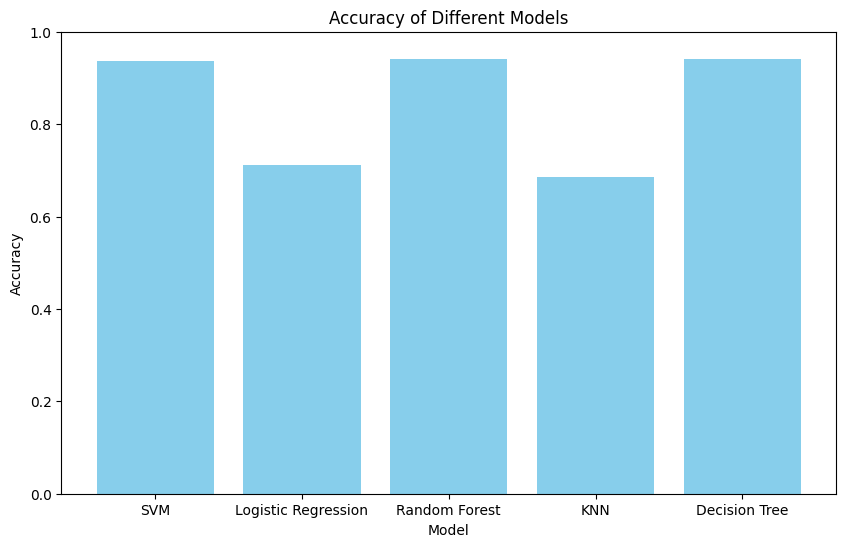

In [76]:
# List of model names
models = ['SVM', 'Logistic Regression', 'Random Forest', 'KNN', 'Decision Tree']

# List of accuracies for each model
accuracies = [accuracy_svm, accuracy_lr, accuracy_rf, accuracy_knn, accuracy_dt]

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0.0, 1.0)  # Set the y-axis limit from 0 to 1
plt.show()

# Computation graph

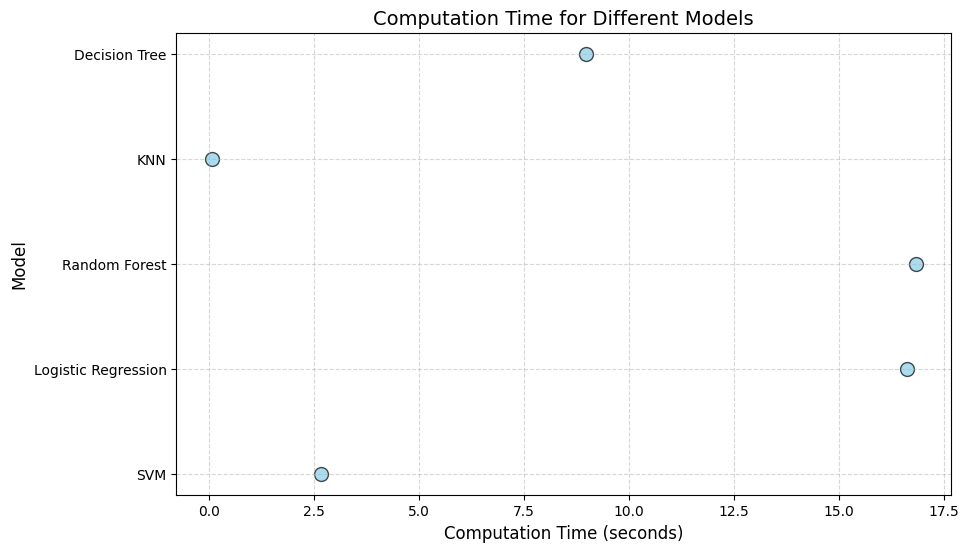

In [77]:
# List of computation times for each model 
computation_times = [time_svm, time_lr, time_rf, time_knn, time_dt]

plt.figure(figsize=(10, 6))
plt.scatter(computation_times, models, color='skyblue', edgecolor='black', s=100, alpha=0.7)
plt.xlabel('Computation Time (seconds)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('Computation Time for Different Models', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

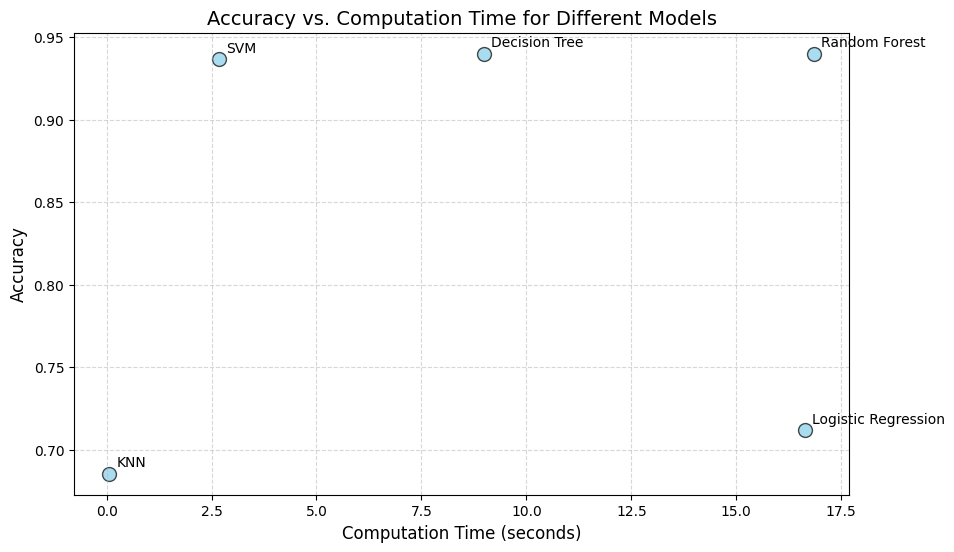

In [78]:

plt.figure(figsize=(10, 6))
plt.scatter(computation_times, accuracies, color='skyblue', edgecolor='black', s=100, alpha=0.7)
plt.xlabel('Computation Time (seconds)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs. Computation Time for Different Models', fontsize=14)
for model, time, accuracy in zip(models, computation_times, accuracies):
    plt.annotate(model, (time, accuracy), xytext=(5, 5), textcoords='offset points', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [79]:
def chatbot():
    print("Chatbot: Hello! I'm your mental health care assistant. Let's talk about how you're feeling today.")
    user_name = input("Chatbot: Before we begin, may I know your name please? ")


    print(f"Chatbot: Nice to meet you, {user_name}! How can I assist you today? Type 'exit' to end our conversation.")

    while True:
        # Take the user's input
        user_input = input(f"{user_name}: ")
        # Check if the user wants to exit the conversation
        if user_input.lower() in ['exit', 'quit']:
            print(f"Chatbot: Thank you for talking with me, {user_name}. Take care!")
            break

        # Predict responses using different models
        response_svm = predict_input_svm(trained_pipeline_svm,  user_input)
        response_lr = predict_input_lr(trained_pipeline_lr, user_input)
        response_rf = predict_input_rf(pipeline_rf, user_input)
        response_dt = predict_input_dt(pipeline_DTree,user_input)
        response_knn = predict_input_knn(pipeline_KNN,user_input)

        # Combine responses from different models
        combined_response = f"SVM: {response_svm}\nLogistic Regression: {response_lr}\nRandom Forest: {response_rf}\nDecision Tree: {response_dt}\nKNN: {response_knn}"

        print("Chatbot:", combined_response)


In [80]:
# Call the chatbot function to start the conversation
chatbot()

In [81]:
import joblib

# Save svm model
joblib.dump(trained_pipeline_svm, 'svm_model.joblib')

# Save random forest model
joblib.dump(pipeline_rf, 'random_forest_model.joblib')


['random_forest_model.joblib']

In [82]:
# from google.colab import files
files.download('svm_model.joblib')

In [83]:
pip freeze


In [84]:
pip freeze > 'requirements.txt'